# Dataton BC 2018

*Dirección de Capacidades Analíticas y Gobierno de Información, Grupo Bancolombia*<br>
Esta versión: *2018-10-17*<br>
Documentación tablas

## Naturaleza de los datos

Los datos entregados en este reto corresponden a transacciones realizadas por clientes persona del banco vía [PSE](https://www.pse.com.co/inicio). Estas transacciones, a diferencia de las transacciones realizadas vía POS, no cuentan con un código [MCC](https://en.wikipedia.org/wiki/Merchant_category_code) atado a la transacción, que permite conocer la categoría de comercio a la que pertence el establecimiento de comercio donde se realiza la transacción. Adicionalmente, muchas de estas transferencias por PSE corresponden a transferencias de pagos de servicios públicos, seguros, colegios, arrendamientos, y otros gastos que pueden ser denominados como gastos grandes. En el marco de un sistema de gestión de finanzas personales, poder categorizar adecuadamente estas transacciones que se realizan por PSE es de suma importancia para contar con una foto completa de la actividad de gastos de los clientes. Para este reto, los equipos participantes tendrán acceso a una muestra de transacciones PSE que corresponden a algo más de 300 mil clientes (persona), seleccionados de manera aleatoria. La tabla de transacciones cuenta con 11.8 millones de registros (uno para cada transacción), realizados entre septiembre de 2016 y octubre de 2018.

**NOTA** Los datos han pasado por un proceso relativamente simple de curación, pero se han dejado algunos ruidos en la calidad de éstos con el fin de que los equipos también lleven a cabo un proceso de inspección y limpieza.

## Tablas

### dt_trxpse_personas_2016_2018_muestra_adjt

* Tabla con transacciones PSE durante 2016-09 a 2018-10 (muestra aleatoria de clientes persona -- 340 mil clientes --)

| **Campo**     | **Descripción**                    | **Tipo**       |
| ------------- |:----------------------------------:|:--------------:|
| id_trn_ach    | identificador único de transacción | string         |
| id_cliente    | id. único de cliente (pagador)     | bigint         |
| fecha         | fecha de transacción               | decimal(8,0)   |
| hora          | hora de transacción (HHMMSS)       | decimal(6,0)   |
| valor_trx     | valor ($) transacción              | double         |
| ref1          | texto libre referencia 1           | string         |
| ref2          | texto libre referencia 2           | string         |
| ref3          | texto libre referencia 3           | string         |
| sector        | sector eco. receptor               | varchar(24)    |
| subsector     | subsector eco. receptor            | varchar(62)    |
| descripcion   | descripción subsector receptor     | varchar(24)    |

## NOTA IMPORTANTE

Recuerden que esta información aún contiene un elevado nivel de ruido. No solo no ha sido depurada de posibles datos atípicos (transacciones de valor muy elevado) fruto de errores o transacciones fallidas, sino que también cuenta con el ruido asociado al campo de referencia, donde se involucra el factor humano, ya que son campos de texto libre que pueden contener cualquier tipo de información.

Por seguridad, hemos eliminado cualquier número presente en dichos campos de referencia (cédulas, nits, montos, contratos, etc.).


In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import random
import time
%matplotlib inline
import matplotlib.animation as animation
import csv
matplotlib.style.use('seaborn')

from sklearn import preprocessing

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn import manifold
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster import hierarchy
from sklearn.cluster import DBSCAN
from sklearn.metrics.pairwise import pairwise_distances
# from wordcloud import WordCloud

from mpl_toolkits.mplot3d import Axes3D

## Ideas
* Identificar outliers respecto a transacciones

Mirar una transacción respecto al tiempo y a la persona que la realiza
compararla con otras personas cercanas y compararla con otras transacciones similares y también las cercanas en el tiempo 

# PreProcesamiento de los datos
Carga de los archivos y exploración de las variables


# Carga y procesamiento de transacciones 

29.607567469278973 minutos de procesamiento | 11818381 Registros procesados | 331 Excepciones | 47832 Lineas con error de longitud

In [2]:
transac_colnames=["id_trn_ach","id_cliente","fec_hor","valor_trx","ref","sector","subsector","descripcion"]

In [3]:
err_characters=[]
inic_loop=time.time()

ln_count=0
counter=0
err_dif_11_count=0

err_lin_count=0

camps_12_count=0
camps_12_list=[]
err_lin_list=[]

except_count=0
except_list=[]


with open("dt_trxpse_personas_2016_2018_muestra_adjt.csv",'r',encoding="utf-8") as dest_f:
    data_iter = csv.reader(dest_f,delimiter = ",",quoting=3)
    for data in data_iter:
        ln_count+=1
#         if counter<20e6: #20 millones
        try:
            if len(data)==11:
                data = [w.replace('\\N', '') for w in data]
                data = [w.replace("null", '') for w in data]
                data = [w.replace(";", '') for w in data]
                with open('transacs_out.csv', 'a', newline='') as file_out:
                    line=[data[0],
                          data[1],
                          data[2]+data[3],
                          data[4],
                          data[5]+" "+data[6]+" "+data[7],
                          data[8],
                          data[9],
                          data[10]]
                    writer = csv.writer(file_out)
                    writer.writerow(line)
                counter+=1
            elif len(data)==12:
                data = [w.replace('\\N', '') for w in data]
                data = [w.replace("null", '') for w in data]
                data = [w.replace(";", '') for w in data]
                with open('transacs_out.csv', 'a', newline='') as file_out:
                    line=[data[0],
                          data[1],
                          data[2]+data[3],
                          data[4],
                          data[5]+" "+data[6]+" "+data[7],
                          data[8],
                          data[9],
                          data[10]+" "+data[11]]
                    writer = csv.writer(file_out)
                    writer.writerow(line)
                camps_12_list.append(counter)#data[0])
                counter+=1
            else:
                err_lin_count+=1
                err_lin_list.append(ln_count)
        except:
            except_count+=1
            except_list.append(ln_count)
            continue
#         else:
#             break

end_loop=time.time()

print((end_loop-inic_loop)/60,"minutos de procesamiento |\n",
      counter,"Registros procesados |\n",
      err_lin_count,"Excepciones |\n",
      len(camps_12_list), "Lineas con 13 campos de longitud |\n",
      err_lin_count, "Líneas con valores diferentes a 12 o 13|\n",
      except_count,"Excepciones |\n")

29.33419470389684 minutos de procesamiento |
 11839512 Registros procesados |
 26701 Excepciones |
 21131 Lineas con 13 campos de longitud |
 26701 Líneas con valores diferentes a 11 o 12|
 331 Excepciones |



Este loop hace 2 validaciones:

* Si hay 12 dimensiones para cada registro:
    * une los valores de fecha y hora en uno solo
    * Deja un solo campo de referencia de las 3 referencias fusionadas
    
    
* Si hay 13 dimensiones para cada registro(se hizo necesario incluir una excepción al procesamiento): 
    * une los valores de fecha y hora en uno solo
    * Deja un solo campo de referencia de las 3 referencias fusionadas
    * Se encontró una coma en el descriptor de ciertas transacciones
        * Sector: SERVICIOS NO FINANCIEROS
        * Subsector: /SERVICIOS A EMPRESAS
        * Descripción: **Procesamiento de datos, alojamiento (hosting) y actividades relacionadas**
          
          En vista de esto, se unieron los dos últimos valores del registro unificando las columnas

Los saltos de lineas dentro de los descriptores producen saltos en los registros, separándolos. Estas líneas se omitieron



# Cargar pandas procesado

In [4]:
transac_colnames=["id_trn_ach","id_cliente","fec_hor","valor_trx","ref","sector","subsector","descripcion"]
transacs_tot=pd.read_csv("transacs_out.csv",header=None,names=transac_colnames,encoding = "latin1")#["id_trn_ach","id_cliente","fec_hor", "valor_trx"])

FileNotFoundError: File b'transacs_out.csv' does not exist

In [ ]:
transacs_tot.fec_hor=pd.to_datetime(transacs_tot.fec_hor,format="%Y%m%d%H%M%S", errors='coerce')

In [ ]:
print(transacs_tot.shape)
print(transacs_tot.dtypes)
transacs_tot.head(20)

# Outliars



# cantidad transacción

In [7]:
transacs_tot.valor_trx.describe()

count    1.183951e+07
mean     3.670536e+05
std      1.596215e+06
min      1.000000e-02
25%      5.200712e+04
50%      1.261556e+05
75%      3.019570e+05
max      1.788605e+09
Name: valor_trx, dtype: float64

In [8]:
quantile_transformer = preprocessing.QuantileTransformer(random_state=0)
centil_valor_trx = quantile_transformer.fit_transform(np.array(transacs_tot.valor_trx).reshape(-1, 1))
centil_valor_trx

array([[0.97246961],
       [0.54618222],
       [0.40348738],
       ...,
       [0.70225366],
       [0.74459773],
       [0.7841806 ]])

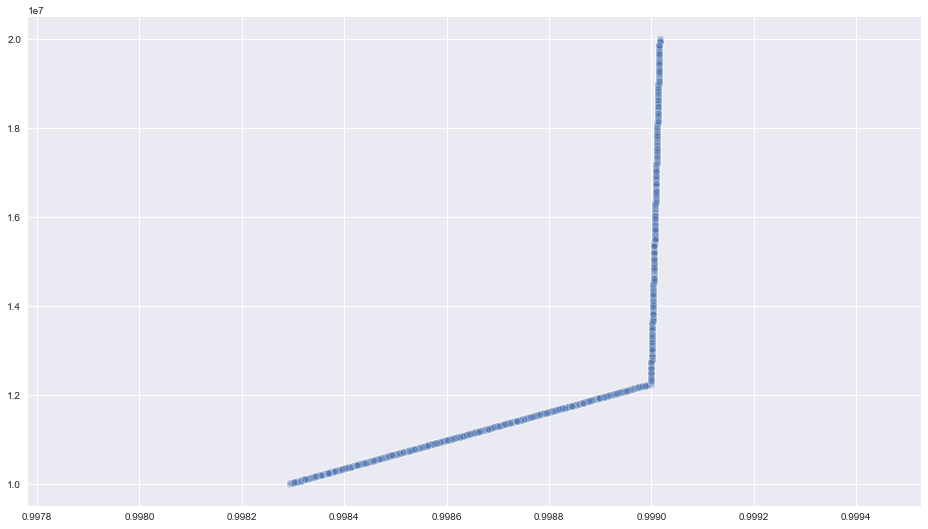

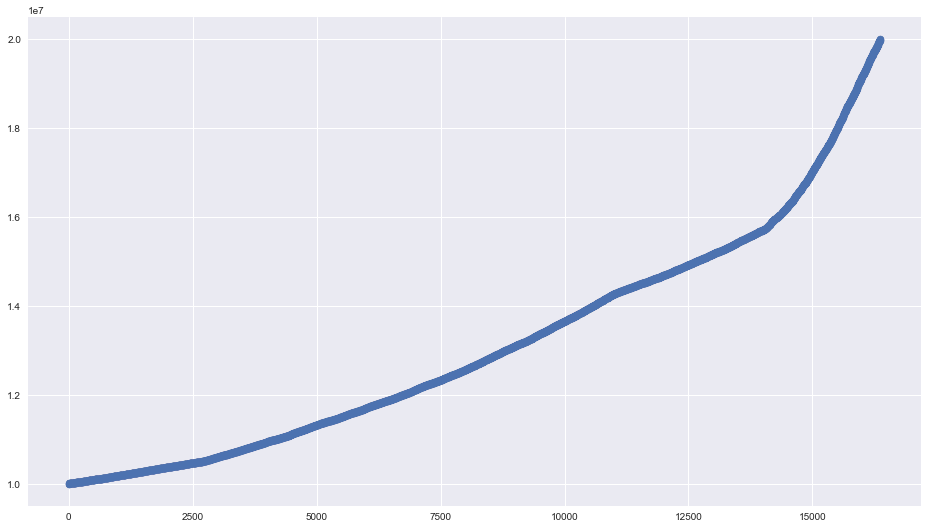

In [9]:
lim_inf=10e6
lim_sup=20e6

plt.figure(figsize=(16,9))
transacs_arr=np.array(transacs_tot.valor_trx).reshape(-1, 1)
sns.scatterplot(centil_valor_trx[(transacs_arr>lim_inf)&(transacs_arr<lim_sup)],
                transacs_arr    [(transacs_arr>lim_inf)&(transacs_arr<lim_sup)], alpha=0.01)#.005))

plt.figure(figsize=(16,9))
plt.scatter(x=range(len(transacs_arr[(transacs_arr>=lim_inf)&(transacs_arr<=lim_sup)])),
            y=np.sort(transacs_arr[(transacs_arr>=lim_inf)&(transacs_arr<=lim_sup)]), alpha=0.01)#.005)

In [10]:
print("CONTEOS")
print (sum((transacs_arr<20e6)&(transacs_arr>16e6)), "Transacciones entre 16 y 20 mill")
print (sum((transacs_arr>16e6)), "Transacciones mayores a 16 mill")
print (sum((transacs_arr>20e6)), "Transacciones mayores a 20 mill")
print (sum((transacs_arr<=16e6)), "Transacciones Menores a 16 mill")
print (sum((transacs_arr<=20e6)), "Transacciones Menores a 20 mill")

print("\n","DESVIACIONES ESTÁNDAR")
print (transacs_arr[(transacs_arr<20e6)&(transacs_arr>16e6)].std(), "Transacciones entre 16 y 20 mill")
print (transacs_arr[transacs_arr>16e6].std(), "Transacciones mayores a 16 mill")
print (transacs_arr[transacs_arr>20e6].std(), "Transacciones mayores a 20 mill")
print (transacs_arr[transacs_arr<=16e6].std(), "Transacciones menores a 16 mill")
print (transacs_arr[transacs_arr<=20e6].std(), "Transacciones menores a 20 mill")


CONTEOS
[2070] Transacciones entre 16 y 20 mill
[5925] Transacciones mayores a 16 mill
[3855] Transacciones mayores a 20 mill
[11833587] Transacciones Menores a 16 mill
[11835657] Transacciones Menores a 20 mill

 DESVIACIONES ESTÁNDAR
1192405.4371143472 Transacciones entre 16 y 20 mill
51421406.95933289 Transacciones mayores a 16 mill
62069457.241783805 Transacciones mayores a 20 mill
816689.0819851798 Transacciones menores a 16 mill
848653.2664377928 Transacciones menores a 20 mill


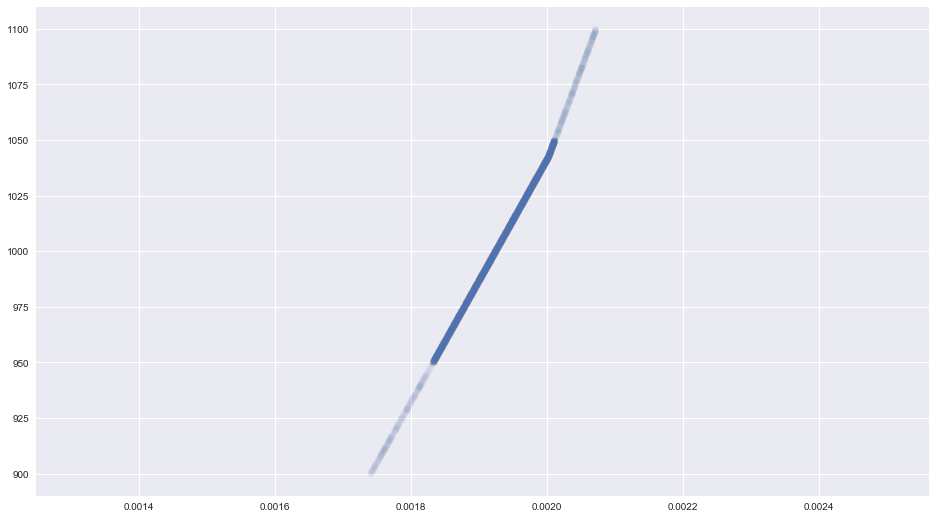

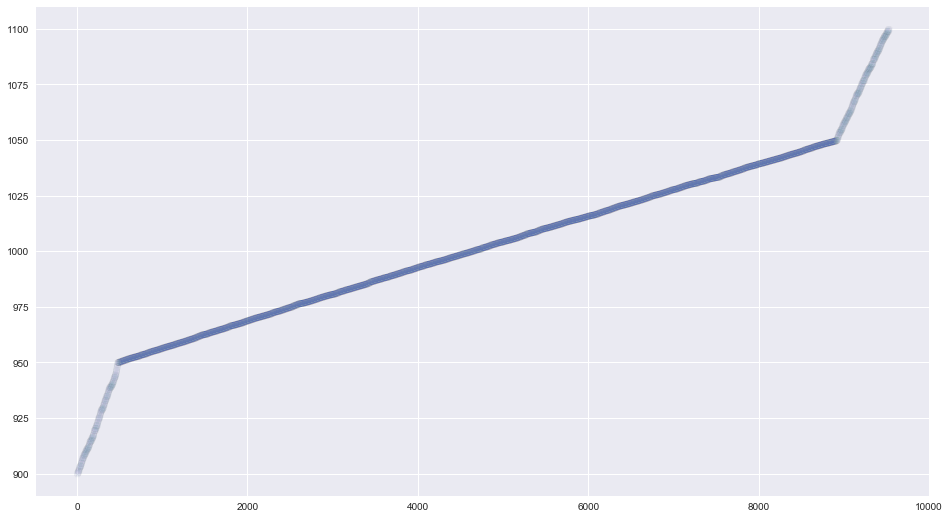

In [11]:
lim_inf=900
lim_sup=1100

plt.figure(figsize=(16,9))
transacs_arr=np.array(transacs_tot.valor_trx).reshape(-1, 1)
sns.scatterplot(centil_valor_trx[(transacs_arr>lim_inf)&(transacs_arr<lim_sup)],
                transacs_arr    [(transacs_arr>lim_inf)&(transacs_arr<lim_sup)], alpha=0.01)

plt.figure(figsize=(16,9))
plt.scatter(x=range(len(transacs_arr[(transacs_arr>=lim_inf)&(transacs_arr<=lim_sup)])),
            y=np.sort(transacs_arr[(transacs_arr>=lim_inf)&(transacs_arr<=lim_sup)]), alpha=0.01)

In [12]:
print("CONTEOS")
print (sum((transacs_arr<1600)&(transacs_arr>950)), "Transacciones entre 950 y 1600 ")
print (sum((transacs_arr<950)), "Transacciones Menores a 950")
print (sum((transacs_arr<1600)), "Transacciones Menores a 1600")
print (sum((transacs_arr>=950)), "Transacciones mayores a 950")
print (sum((transacs_arr>=1600)), "Transacciones mayores a 1600")

print("\n","DESVIACIONES ESTÁNDAR")
print (transacs_arr[(transacs_arr<1600)&(transacs_arr>1000)].std(), "Transacciones entre 950 y 1600 ")
print (transacs_arr[transacs_arr<1000].std(), "Transacciones Menores a 950")
print (transacs_arr[transacs_arr<1600].std(), "Transacciones Menores a 1600")
print (transacs_arr[transacs_arr>=1000].std(), "Transacciones mayores a 950")
print (transacs_arr[transacs_arr>=1600].std(), "Transacciones mayores a 1600")

CONTEOS
[14631] Transacciones entre 950 y 1600 
[16927] Transacciones Menores a 950
[31559] Transacciones Menores a 1600
[11822585] Transacciones mayores a 950
[11807953] Transacciones mayores a 1600

 DESVIACIONES ESTÁNDAR
187.15658467720132 Transacciones entre 950 y 1600 
364.8088557705127 Transacciones Menores a 950
474.0343392970338 Transacciones Menores a 1600
1597562.498782339 Transacciones mayores a 950
1598234.4703419374 Transacciones mayores a 1600


### Eliminar 

### transacciones superiores a 16 millones de pesos
Se encontró que : 
* Al ordenar por percentiles se observa un comportamiento anómalo en el valor de la transacción
* Se observa un efecto techo sobre este valor y un cambio no esperado en el comportamiento de la variable cuando se ordenan las transacciones por su valor
* Por el peso sobre la varianza, respecto a la proporción de datos, consideramos que 16 millones es un criterio discreto para limitar los outliars.


### transacciones menores a 950 pesos
Se encontró que : 
* Se observa un efecto techo sobre este valor y un cambio en el comportamiento de la variable cuando se ordenan las transacciones por su valor
* La revisión de diferentes páginas dan como pago mínimo por PSE valores cercanos a los 1000.

In [13]:
transacs_tot=transacs_tot.loc[(transacs_tot.valor_trx<=16e6)&(transacs_tot.valor_trx>=950)]

In [14]:
transacs_tot.valor_trx.describe()

count    1.181666e+07
mean     3.508401e+05
std      8.171663e+05
min      9.500000e+02
25%      5.217644e+04
50%      1.263564e+05
75%      3.019337e+05
max      1.599997e+07
Name: valor_trx, dtype: float64

### Checkpoint- Guardar filtrados 

In [17]:
transacs_tot.to_csv("transacs_tot.csv")

In [ ]:
transacs_tot=pd.read_csv("transacs_tot.csv",index_col=0)
transacs_tot.fec_hor=pd.to_datetime(transac_tot.fec_hor)
print(transacs_tot.shape)
print(transacs_tot.dtypes)
transacs_tot.head()

# Marcas temporales (Agrupación de Fechas)

Se toman valores de las fechas como features para los algoritmos

## Agregar la codificación del dia del mes y las demás marcas temporales que se le agregaron a todas las transacciones

In [1]:
marcs_temp=["dia_sem_num","dia_mes_num","dia_year_num","hora_num","year_num","mes_num","semana_year_num","period_mens","period_sem"]

In [ ]:
transacs_tot["dia_sem_num"]=transacs_tot.fec_hor.dt.weekday()
transacs_tot["dia_mes_num"]
transacs_tot["dia_year_num"]
transacs_tot["hora_num"]
transacs_tot["year_num"]
transacs_tot["mes_num"]
transacs_tot["semana_year_num"]
transacs_tot["period_mens"]
transacs_tot["period_sem"]

In [6]:
transacs_tot.fec_hor.dt.weekday()

NameError: name 'transacs_tot' is not defined

## Frecuencia de las transacciones de los clientes

In [18]:
freq_idclients=pd.crosstab(transacs_tot.id_cliente, columns="count")
freq_idclients["id_cliente"]=freq_idclients.index
print(freq_idclients.shape)
freq_idclients.head(10)

(338418, 2)


col_0,count,id_cliente
id_cliente,,
1,26,1
2,6,2
3,53,3
4,7,4
5,27,5
6,12,6
7,1,7
8,1,8
9,33,9


In [21]:
val_tot_transac=pd.DataFrame(transacs_tot[["id_cliente","valor_trx"]].groupby("id_cliente").sum())
val_tot_transac["id_cliente"]=val_tot_transac.index
val_tot_transac.head()

,valor_trx,id_cliente
id_cliente,,
1,42769383.24,1
2,1365034.29,2
3,12058409.54,3
4,2534093.31,4
5,10990697.40,5


# Explorar NULOS

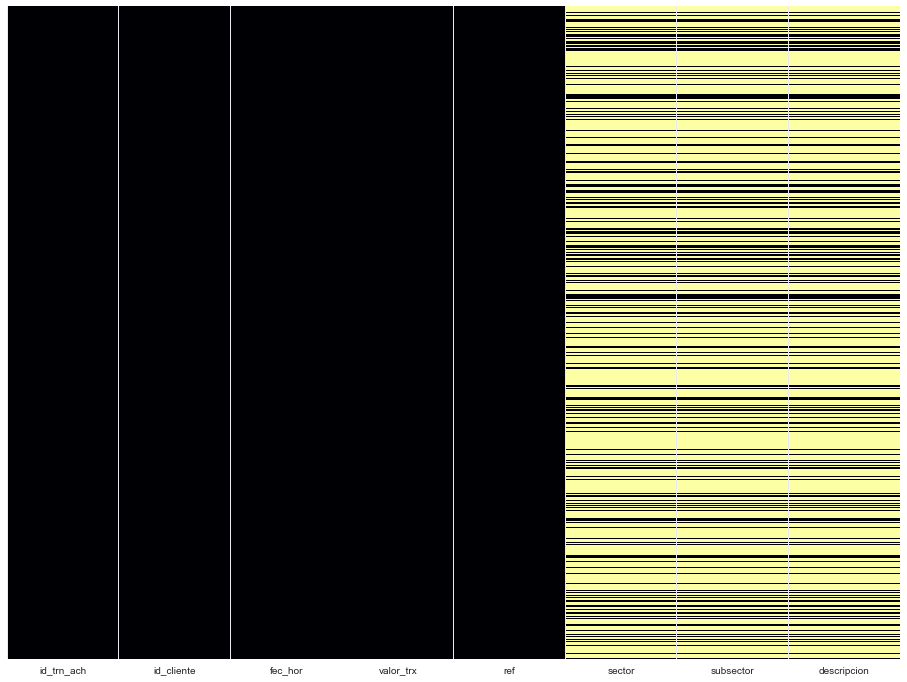

In [16]:
plt.figure(figsize=(16,12))
sns.heatmap(transacs_tot.isnull(),yticklabels=False,cbar=False,cmap='inferno')

In [23]:
client_fr_val = pd.merge(freq_idclients, val_tot_transac, on='id_cliente')
client_fr_val=client_fr_val[["id_cliente","count","valor_trx"]]
client_fr_val.columns=["id_cliente","count","valor_trx_suma"]
client_fr_val.head()
client_fr_val.to_csv("client_fr_val.csv")

C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2961: FutureWarning: 'id_cliente' is both an index level and a column label.
Defaulting to column, but this will raise an ambiguity error in a future version
  exec(code_obj, self.user_global_ns, self.user_ns)


# -------------------------

In [19]:
freq_idclients.sort_values(by=['count'], ascending=False)[:10]

col_0,count,id_cliente
id_cliente,,
210949,6185,210949
187977,5775,187977
26729,5726,26729
157323,5259,157323
122249,5139,122249
66700,4357,66700
131290,3950,131290
228889,3471,228889
52442,3379,52442


id_cliente
210949    6185
187977    5775
26729     5726
157323    5259
122249    5139
66700     4357
131290    3950
228889    3471
52442     3379
274004    3155
191003    3086
110262    3048
191545    2994
190305    2903
146567    2881
125368    2768
188083    2628
261280    2599
273902    2483
22057     2384
39573     2256
188581    2236
14850     2215
186845    2213
37059     2183
190412    2163
188249    2152
189347    2145
189128    2133
189473    2132
          ... 
210936       1
307827       1
82372        1
283556       1
307830       1
251243       1
154157       1
283554       1
82439        1
307812       1
154135       1
307810       1
307790       1
210930       1
251248       1
82528        1
262959       1
197551       1
283567       1
307799       1
82503        1
307802       1
283565       1
283564       1
307805       1
262956       1
251247       1
239555       1
154128       1
227297       1
Name: count, Length: 338418, dtype: int64

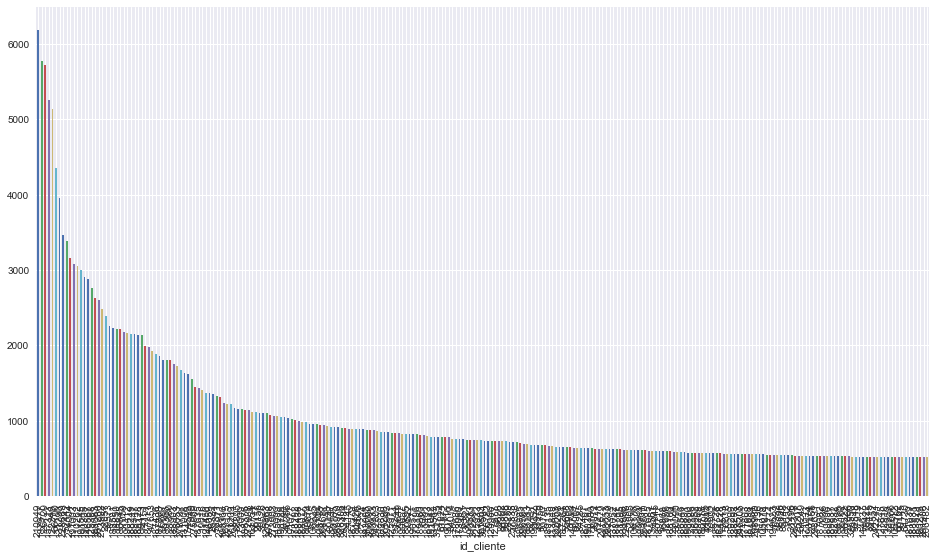

In [20]:
plt.figure(figsize=(16,9))
freq_idclients.sort_values(by=['count'],ascending=False).iloc[:250,0].plot(figsize=(16,9), kind="bar")
freq_idclients.sort_values(by=['count'],ascending=False)["count"]

id_cliente
191003    5.391350e+09
36649     5.257838e+09
188083    3.383835e+09
186845    2.933586e+09
127977    2.594342e+09
189347    2.396974e+09
188903    2.200231e+09
191042    2.035397e+09
27456     2.026458e+09
190219    1.775083e+09
190533    1.695050e+09
190305    1.599196e+09
98267     1.558392e+09
187467    1.507047e+09
269988    1.498918e+09
136072    1.493887e+09
183291    1.446612e+09
189255    1.442038e+09
187808    1.419697e+09
189579    1.408842e+09
189830    1.354564e+09
133441    1.313886e+09
183529    1.288050e+09
49838     1.248218e+09
312715    1.217933e+09
190862    1.157093e+09
183499    1.147160e+09
157323    1.133410e+09
274004    1.113029e+09
188922    1.065309e+09
              ...     
264674    1.008570e+03
238861    1.001170e+03
8540      9.948900e+02
331969    9.946600e+02
25116     9.942600e+02
325234    9.926800e+02
298138    9.920400e+02
243479    9.916600e+02
128790    9.897500e+02
199320    9.890300e+02
560       9.846500e+02
205200    9.816800e+02


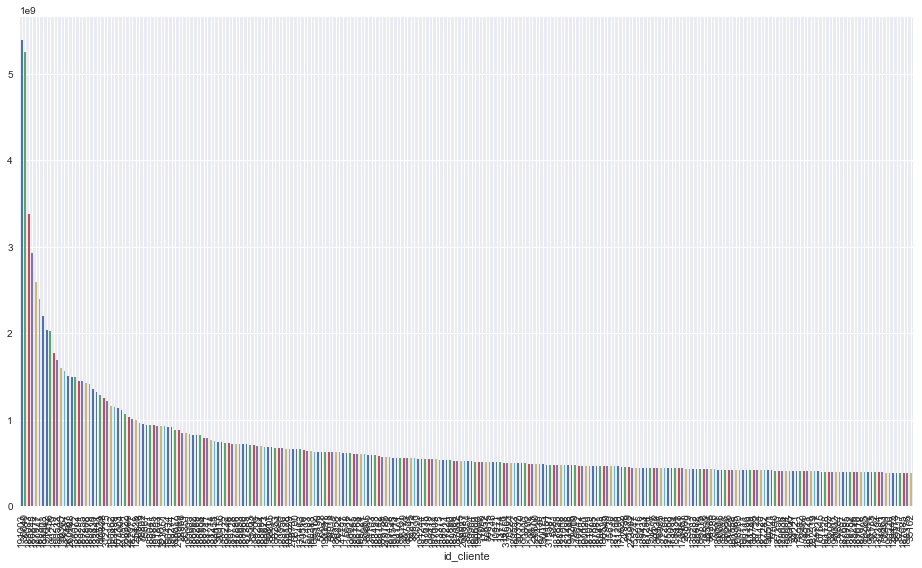

In [22]:
plt.figure(figsize=(16,9))
val_tot_transac.sort_values(by=['valor_trx'],ascending=False).iloc[:250,0].plot(figsize=(16,9), kind="bar")
val_tot_transac.sort_values(by=['valor_trx'],ascending=False)["valor_trx"]

## Clientes frecuencia y suma de transacciones

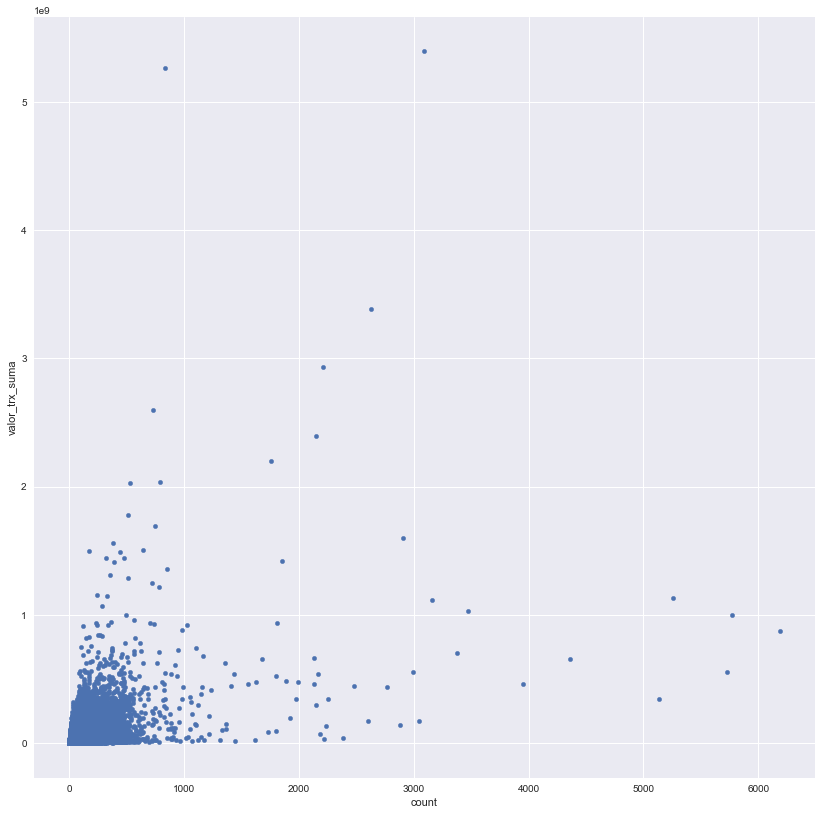

In [24]:
client_fr_val.plot(kind="scatter",x="count", y="valor_trx_suma",figsize=(14,14))

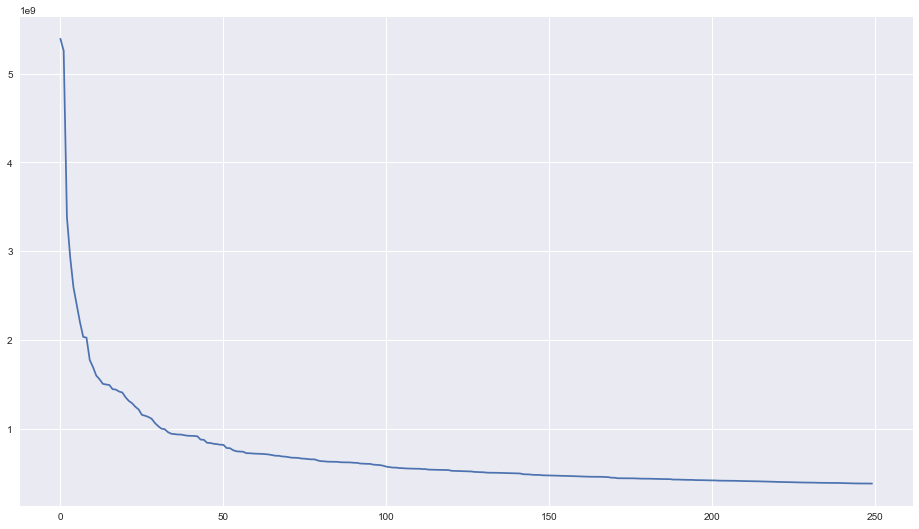

In [25]:
client_fr_val.sort_values(by=['valor_trx_suma'],ascending=False).valor_trx_suma[:250].plot(use_index=False,figsize=(16,9))#, kind="bar")